In [3]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
import re 
from nltk.tokenize import word_tokenize 
from nltk.corpus import stopwords 

# Add src to Python path
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# Imports from src modules
from src.data_processing import load_financial_news_data, preprocess_text_data, extract_date_features
from src.sentiment_tool import add_sentiment_to_df
from src.financial_analysis import calculate_daily_returns, calculate_technical_indicators
from src.visualization_tools import plot_correlation_scatter

# Ensure NLTK resources
try:
    stopwords.words('english'); word_tokenize("test")
except LookupError:
    print("Downloading NLTK resources..."); nltk.download('stopwords', quiet=True); nltk.download('punkt', quiet=True)

In [4]:

STOCK_DATA_FILENAME_TEMPLATE = "{}_historical_data.csv"

def load_stock_prices_from_csvs(tickers: list,
                                csv_directory: str,
                                filename_template: str = STOCK_DATA_FILENAME_TEMPLATE,
                                date_col: str = 'Date',
                                required_ohlcv_cols: list = None) -> dict:
    """
    Loads OHLCV data for given tickers from local CSV files.
    Includes detailed debugging prints.
    """
    stock_data_dict = {}
    if required_ohlcv_cols is None: required_ohlcv_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
    abs_csv_directory = os.path.abspath(csv_directory)
    if not os.path.isdir(abs_csv_directory):
        print(f"--- DEBUG: ERROR - Target directory DOES NOT EXIST: {abs_csv_directory}"); return {}
    try:
        print(f"--- DEBUG: Contents of target directory '{abs_csv_directory}': {os.listdir(abs_csv_directory) or 'EMPTY'}")
    except Exception as e:
        print(f"--- DEBUG: ERROR - Could not list contents: {e}"); return {}

    for ticker_input in tickers:
        ticker_upper = str(ticker_input).upper()
        file_name = filename_template.format(ticker_upper)
        file_path = os.path.join(csv_directory, file_name) 
        abs_file_path = os.path.abspath(file_path)
        if os.path.exists(file_path):
          
            try:
                df = pd.read_csv(file_path)
                if date_col not in df.columns: print(f"W: Date col missing {file_name}"); continue
                df[date_col] = pd.to_datetime(df[date_col], errors='coerce'); df.dropna(subset=[date_col], inplace=True)
                if df.empty: print(f"W: No valid dates {file_name}"); continue
                df.set_index(date_col, inplace=True); df.sort_index(inplace=True)
                actual_cols, missing_essential = {}, False
                for req_col in required_ohlcv_cols:
                    if req_col in df.columns: actual_cols[req_col] = req_col
                    elif req_col.lower() in df.columns.str.lower().values: actual_cols[req_col] = df.columns[df.columns.str.lower() == req_col.lower()][0]
                    elif req_col == 'Close' and 'Adj Close' in df.columns: actual_cols['Close'] = 'Adj Close'
                    elif req_col == 'Close' and df.columns.str.lower().isin(['adj close','adjusted close']).any(): actual_cols['Close'] = df.columns[df.columns.str.lower().isin(['adj close','adjusted close'])][0]
                    elif req_col in ['Open', 'High', 'Low', 'Close', 'Volume']: print(f"W: Essential '{req_col}' MISSING {file_name}"); missing_essential = True; break
                if missing_essential: print(f"Skipping {ticker_input} (missing essential)"); continue
                processed_data = {tgt: df[actual_cols[tgt]] for tgt in required_ohlcv_cols if tgt in actual_cols}
                processed_df = pd.DataFrame(processed_data, index=df.index)
                numerify_cols = [c for c in required_ohlcv_cols if c in processed_df.columns]
                for col in numerify_cols: processed_df[col] = pd.to_numeric(processed_df[col], errors='coerce')
                processed_df.dropna(subset=numerify_cols, how='any', inplace=True)
                if processed_df.empty: print(f"W: No valid data {file_name} after processing"); continue
                stock_data_dict[ticker_upper] = processed_df
            except Exception as e: print(f"E: processing {file_name}: {e}")
        else: print(f"--- DEBUG: File NOT FOUND: {abs_file_path}")
    if not stock_data_dict: print("--- DEBUG: stock_data_dict empty at end.")
    else: print(f"--- DEBUG: Loaded tickers: {list(stock_data_dict.keys())}")
    
    return stock_data_dict


In [5]:

NEWS_DATA_DIR = os.path.join('..', 'data') 
NEWS_FILENAME = 'raw_analyst_ratings.csv'
STOCK_CSV_DIRECTORY = os.path.join('..', 'data', 'raw', 'stock_historical_data') 

ACTUAL_STOCK_TICKERS = ['AAPL', 'AMZN', 'GOOG', 'META', 'MSFT', 'NVDA', 'TSLA']
TICKERS_FOR_DETAILED_ANALYSIS = ACTUAL_STOCK_TICKERS[:7] 

In [ ]:

abs_news_path = os.path.abspath(os.path.join(NEWS_DATA_DIR, NEWS_FILENAME))
abs_stock_path = os.path.abspath(STOCK_CSV_DIRECTORY)
if os.path.isdir(abs_stock_path):
    print(f"Contents of stock CSVs directory ('{abs_stock_path}'): {os.listdir(abs_stock_path)}")

Contents of stock CSVs directory ('/home/fentahun/KAIM-Week1/nova-financial-insights-challenge-week1/data/raw/stock_historical_data'): ['AAPL_historical_data.csv', 'MSFT_historical_data.csv', 'AMZN_historical_data.csv', 'TSLA_historical_data.csv', 'GOOG_historical_data.csv', 'META_historical_data.csv', 'NVDA_historical_data.csv']


In [8]:

news_file_full_path = os.path.join(NEWS_DATA_DIR, NEWS_FILENAME)
news_df_raw = load_financial_news_data(file_path=news_file_full_path)

if news_df_raw is None or news_df_raw.empty:
    if 'ALPHA' in news_df_raw.get('stock', pd.Series()).unique(): print("Loaded DUMMY news data.")
    else: raise SystemExit("Raw news data load failed.")

news_df_text = preprocess_text_data(news_df_raw, 'headline')
if news_df_text.empty and not news_df_raw.empty: raise SystemExit("News text preprocessing failed.")

news_df_processed = extract_date_features(news_df_text, 'date')
if news_df_processed.empty and not news_df_text.empty: raise SystemExit("News date extraction failed.")

TEXT_COL_SENTIMENT = 'processed_headline'
if TEXT_COL_SENTIMENT not in news_df_processed.columns: 
    TEXT_COL_SENTIMENT = 'headline' if 'headline' in news_df_processed.columns else None
    if not TEXT_COL_SENTIMENT: raise SystemExit("No text col for sentiment.")
    else: print(f"Warning: Using '{TEXT_COL_SENTIMENT}' for sentiment analysis.")

news_df_with_sentiment = add_sentiment_to_df(news_df_processed, TEXT_COL_SENTIMENT)
if news_df_with_sentiment.empty and not news_df_processed.empty: raise SystemExit("Sentiment analysis failed.")

print("\nNews Data with Sentiment (Sample):")
display_cols_n = ['headline', TEXT_COL_SENTIMENT, 'stock', 'publication_date_only', 'sentiment_compound', 'sentiment_label']
actual_display_cols_n = [c for c in display_cols_n if c in news_df_with_sentiment.columns]
if actual_display_cols_n: print(news_df_with_sentiment[actual_display_cols_n].head())

Sentiment scores added to DataFrame using column 'processed_headline'.

News Data with Sentiment (Sample):
                                            headline  \
0            Stocks That Hit 52-Week Highs On Friday   
1         Stocks That Hit 52-Week Highs On Wednesday   
2                      71 Biggest Movers From Friday   
3       46 Stocks Moving In Friday's Mid-Day Session   
4  B of A Securities Maintains Neutral on Agilent...   

                                  processed_headline stock  \
0                       stocks hit week highs friday     A   
1                    stocks hit week highs wednesday     A   
2                              biggest movers friday     A   
3               stocks moving friday mid day session     A   
4  securities maintains neutral agilent technolog...     A   

  publication_date_only  sentiment_compound sentiment_label  
0            2020-06-05               0.000         neutral  
1            2020-06-03               0.000         neutral

In [ ]:

print(f"\n--- Calling load_stock_prices_from_csvs for stock data ---")
all_stock_data_loaded = load_stock_prices_from_csvs(
    tickers=ACTUAL_STOCK_TICKERS,
    csv_directory=STOCK_CSV_DIRECTORY
)

all_stock_data_for_corr = {} 
if not all_stock_data_loaded:
    raise SystemExit("Critical error: load_stock_prices_from_csvs returned no data.")

for ticker, stock_df_raw_loaded in all_stock_data_loaded.items():
    if stock_df_raw_loaded is not None and not stock_df_raw_loaded.empty:
        df_returns = calculate_daily_returns(stock_df_raw_loaded.copy(), 'Close')
        if not df_returns.empty:
            temp_df = df_returns.reset_index()
            temp_df['Date'] = pd.to_datetime(temp_df['Date']).dt.date
            all_stock_data_for_corr[ticker] = temp_df
        else: print(f"No returns for {ticker}.")
    else: print(f"No stock data for {ticker} from loader.")

if not all_stock_data_for_corr:
    raise SystemExit("Critical error: No stock data for correlation after returns.")
print(f"\nProcessed stock data with returns for {len(all_stock_data_for_corr)} tickers.")

if TICKERS_FOR_DETAILED_ANALYSIS and ACTUAL_STOCK_TICKERS[0] in all_stock_data_for_corr: 
    sample_tick = ACTUAL_STOCK_TICKERS[0]
    print(f"\nStock Returns for {sample_tick} (Sample):")
    print(all_stock_data_for_corr[sample_tick][['Date', 'Close', 'daily_return']].head())


--- Calling load_stock_prices_from_csvs for stock data ---
--- DEBUG: Contents of target directory '/home/fentahun/KAIM-Week1/nova-financial-insights-challenge-week1/data/raw/stock_historical_data': ['AAPL_historical_data.csv', 'MSFT_historical_data.csv', 'AMZN_historical_data.csv', 'TSLA_historical_data.csv', 'GOOG_historical_data.csv', 'META_historical_data.csv', 'NVDA_historical_data.csv']
--- DEBUG: Loaded tickers: ['AAPL', 'AMZN', 'GOOG', 'META', 'MSFT', 'NVDA', 'TSLA']

Processed stock data with returns for 7 tickers.

Stock Returns for AAPL (Sample):
         Date     Close  daily_return
0  1980-12-12  0.128348           NaN
1  1980-12-15  0.121652     -0.052171
2  1980-12-16  0.112723     -0.073398
3  1980-12-17  0.115513      0.024751
4  1980-12-18  0.118862      0.028992



--- Processing Correlation for AAPL ---
Contemporaneous correlation (Sentiment vs. Return) for AAPL: 0.0134
Lagged T+1 correlation (Sentiment Today vs. Return Tomorrow) for AAPL: -0.0040


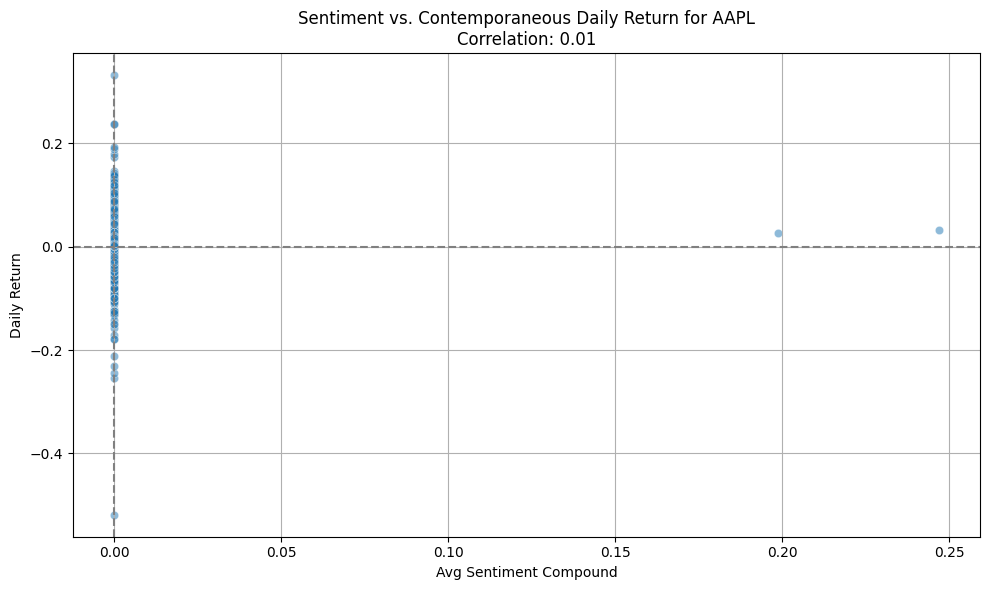

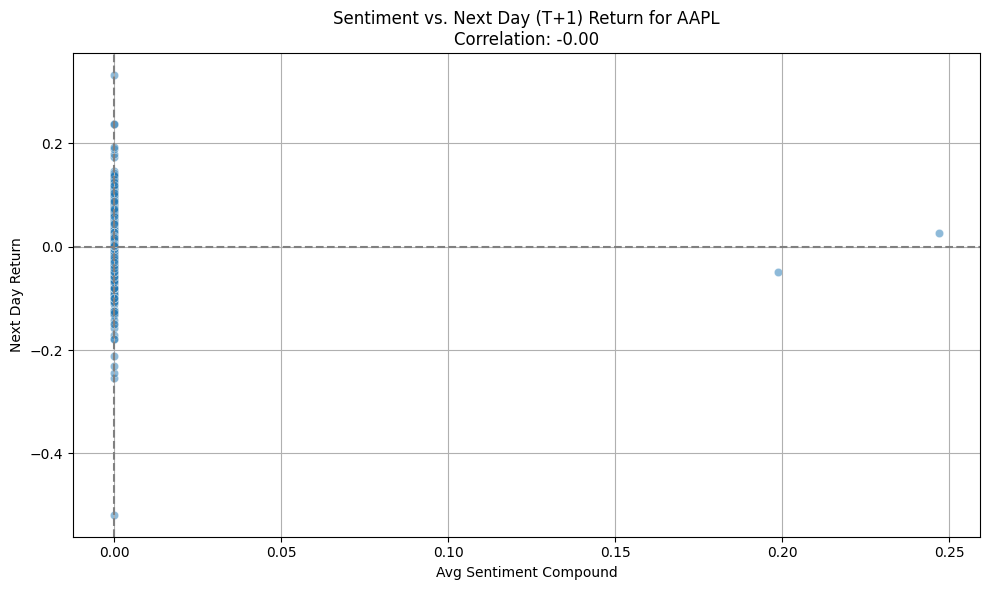


--- Processing Correlation for AMZN ---
Contemporaneous correlation (Sentiment vs. Return) for AMZN: 0.0082
Lagged T+1 correlation (Sentiment Today vs. Return Tomorrow) for AMZN: -0.0099


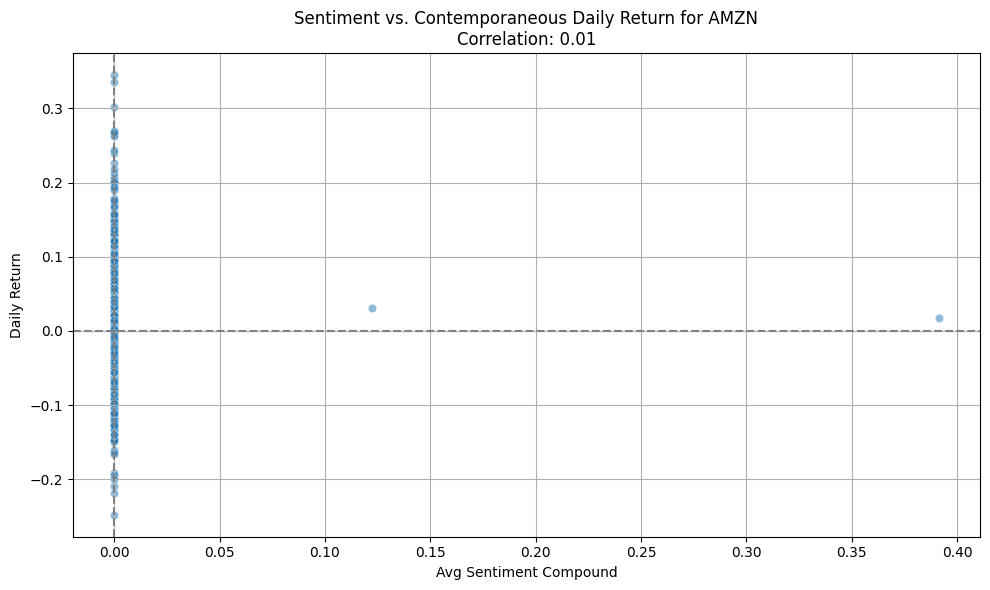

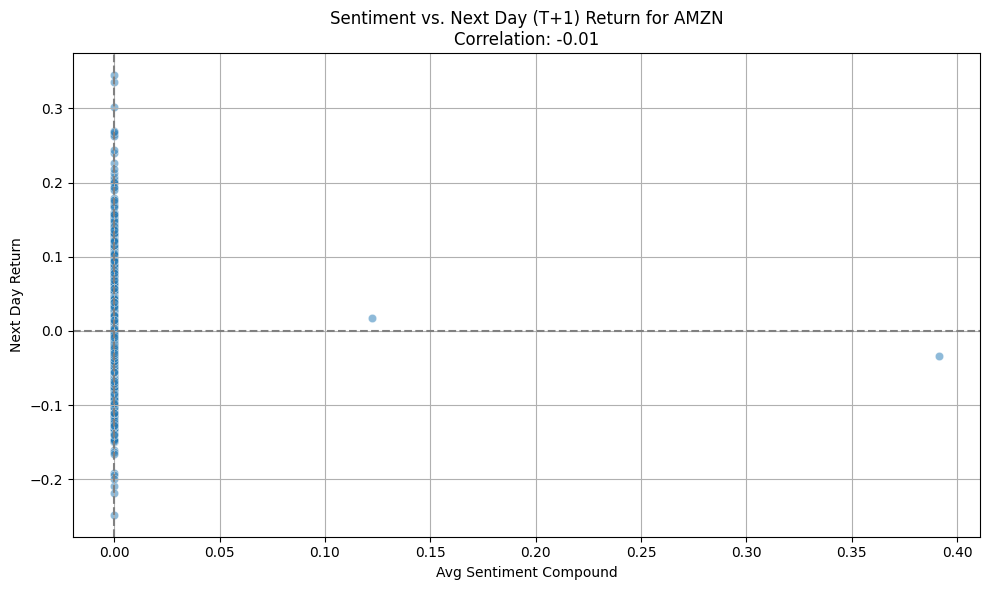


--- Processing Correlation for GOOG ---
Contemporaneous correlation (Sentiment vs. Return) for GOOG: -0.0030
Lagged T+1 correlation (Sentiment Today vs. Return Tomorrow) for GOOG: -0.0116


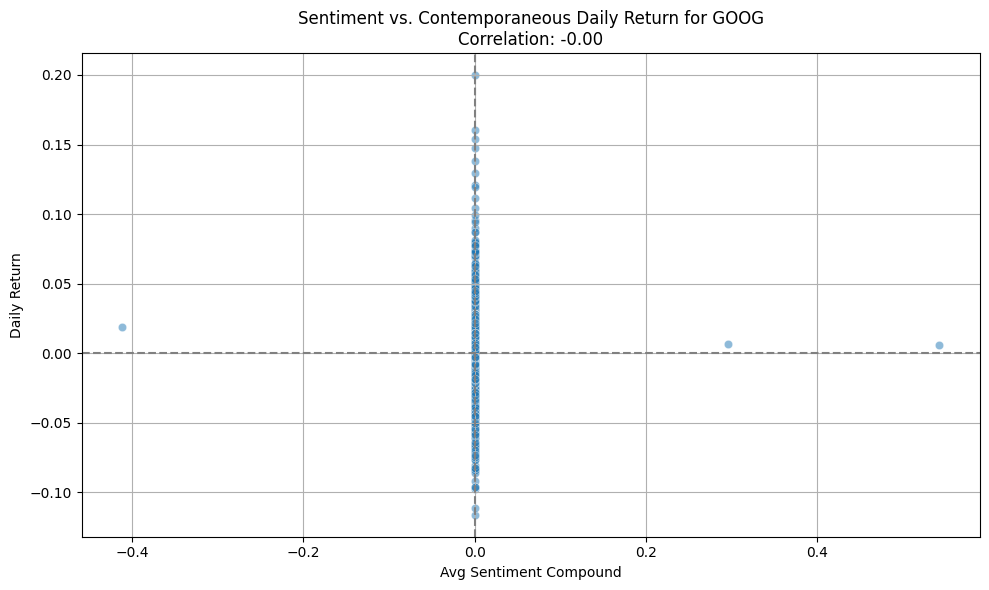

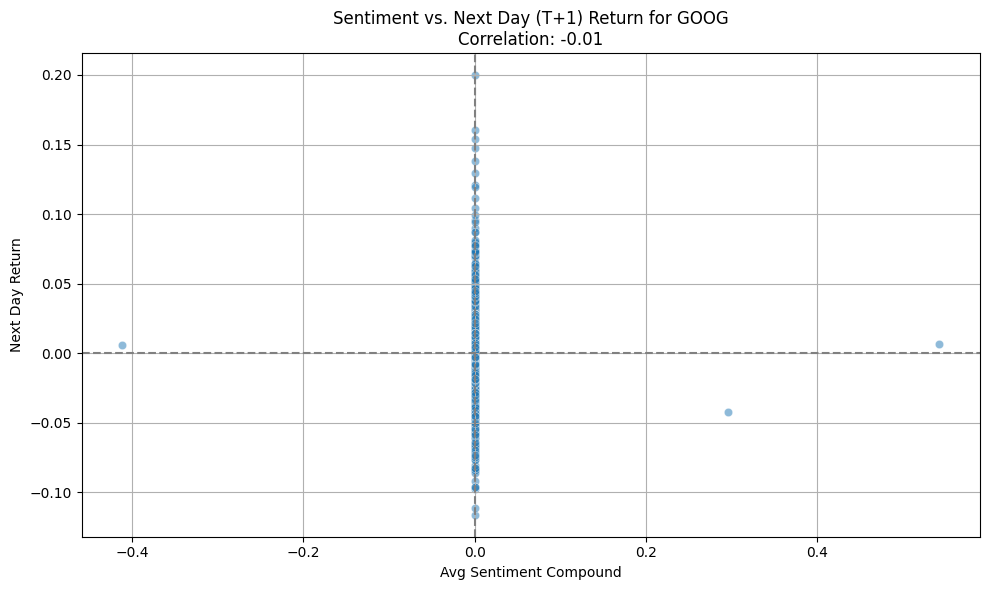

Skipping META: no news data found for ticker 'META' in news 'stock' column.
Skipping MSFT: no news data found for ticker 'MSFT' in news 'stock' column.

--- Processing Correlation for NVDA ---
Contemporaneous correlation (Sentiment vs. Return) for NVDA: 0.0098
Lagged T+1 correlation (Sentiment Today vs. Return Tomorrow) for NVDA: 0.0047


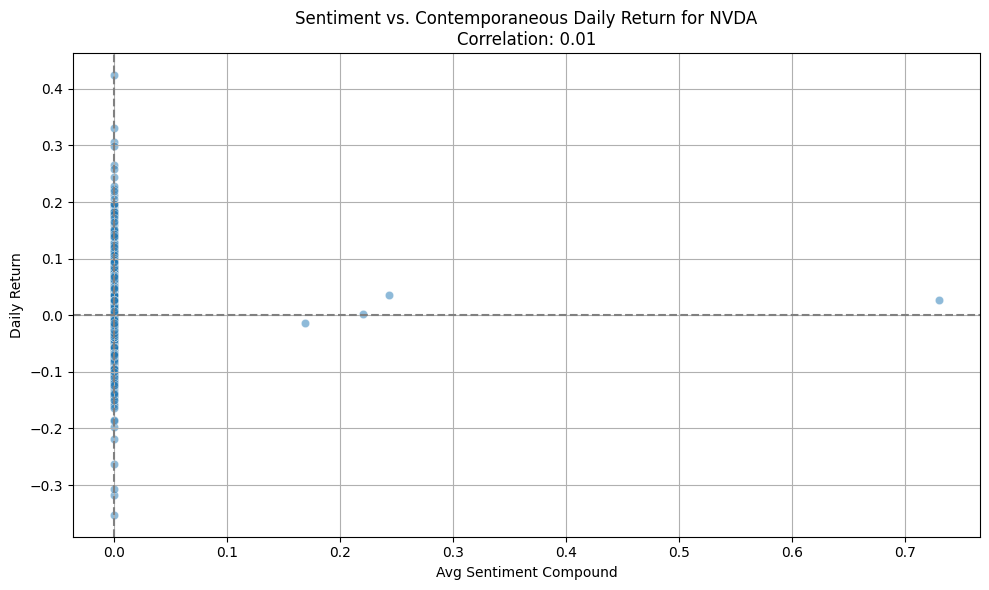

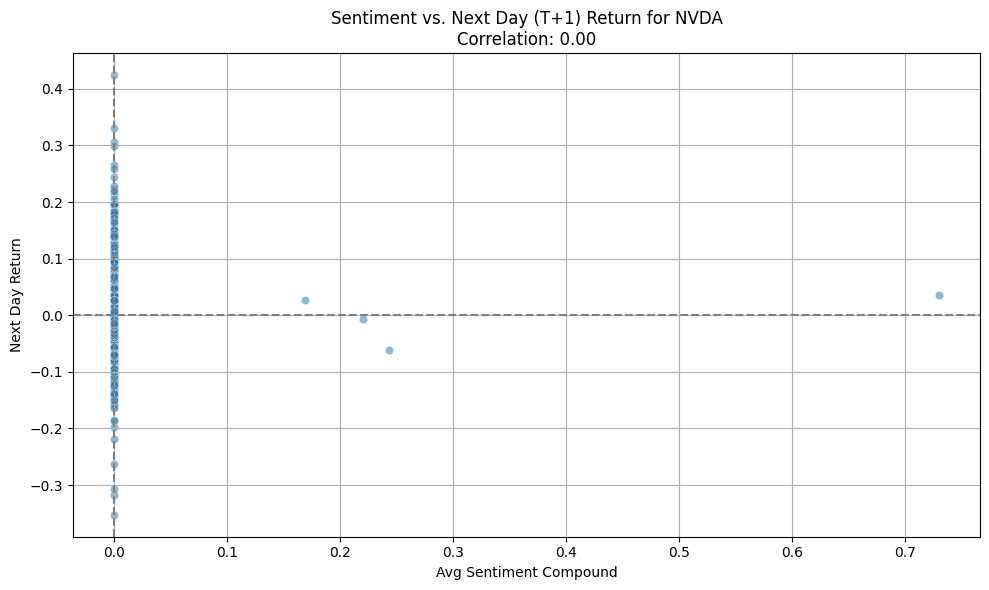


--- Processing Correlation for TSLA ---
Contemporaneous correlation (Sentiment vs. Return) for TSLA: 0.0411
Lagged T+1 correlation (Sentiment Today vs. Return Tomorrow) for TSLA: -0.0248


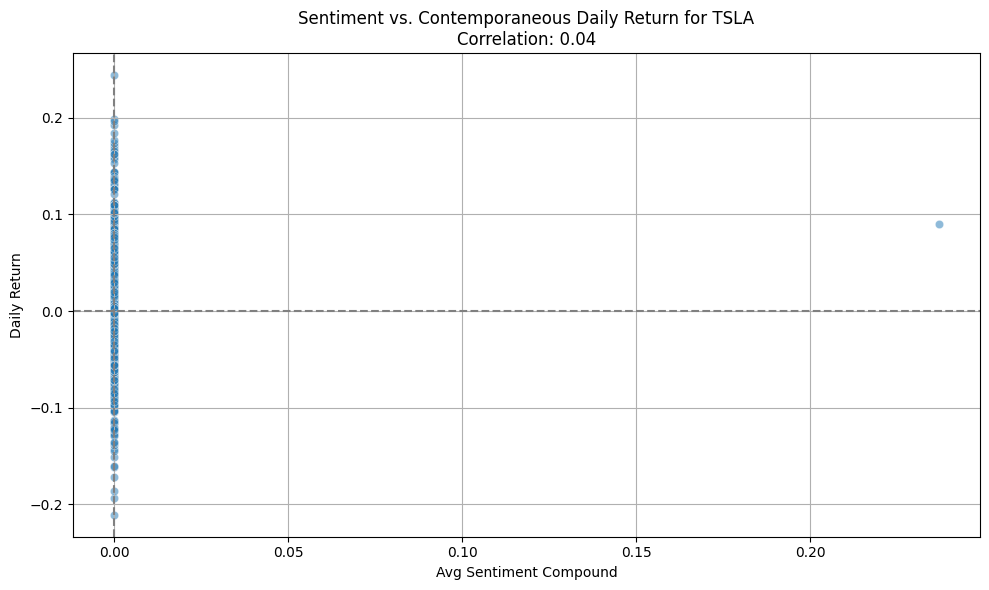

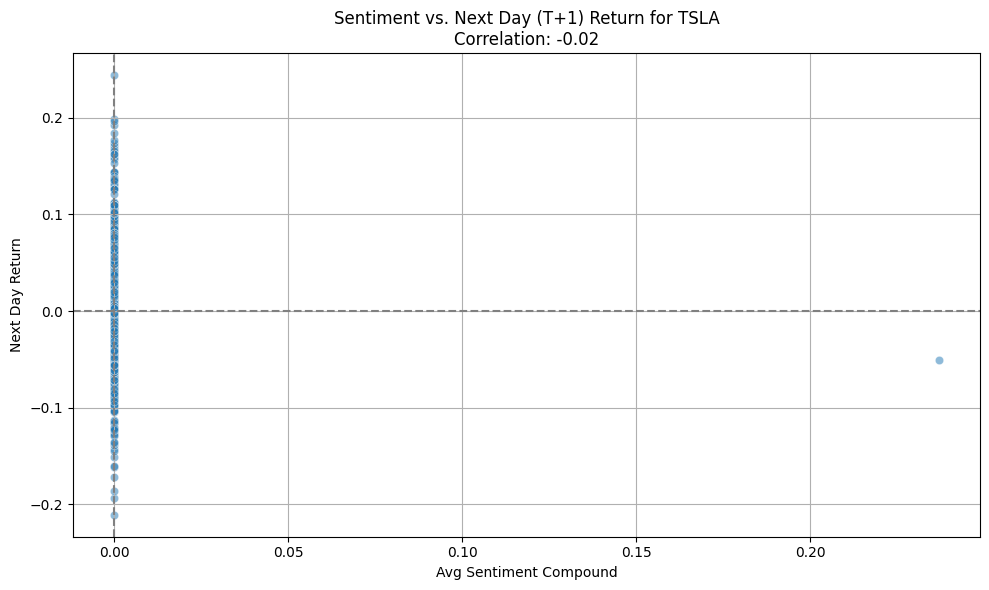

In [10]:

if 'publication_date_only' not in news_df_with_sentiment.columns:
    raise SystemExit("Critical error: 'publication_date_only' column missing from news data.")

correlation_results = {}
all_merged_data_list = [] 

for ticker in ACTUAL_STOCK_TICKERS:
    if ticker not in all_stock_data_for_corr or all_stock_data_for_corr[ticker].empty:
        continue
    if ticker not in news_df_with_sentiment['stock'].unique():
        print(f"Skipping {ticker}: no news data found for ticker '{ticker}' in news 'stock' column.")
        continue

    print(f"\n--- Processing Correlation for {ticker} ---")
    ticker_news_df = news_df_with_sentiment[news_df_with_sentiment['stock'] == ticker].copy()
    if ticker_news_df.empty: 
        print(f"No news articles found for {ticker} after filtering.")
        continue
        
    if 'publication_date_only' not in ticker_news_df.columns or 'sentiment_compound' not in ticker_news_df.columns:
        print(f"Error: Missing 'publication_date_only' or 'sentiment_compound' for ticker {ticker} in ticker_news_df.")
        continue
    
    daily_sentiment_agg = ticker_news_df.groupby('publication_date_only')['sentiment_compound'].mean().reset_index()
    daily_sentiment_agg.rename(columns={'publication_date_only': 'Date', 
                                        'sentiment_compound': 'avg_sentiment_compound'}, inplace=True)
    
    ticker_stock_df = all_stock_data_for_corr[ticker]
    
    merged_df = pd.merge(ticker_stock_df, daily_sentiment_agg, on='Date', how='left')
    merged_df['avg_sentiment_compound'] = merged_df['avg_sentiment_compound'].fillna(0)
    
    merged_df.dropna(subset=['daily_return'], inplace=True)

    if merged_df.empty or len(merged_df) < 2: 
        print(f"Not enough data points after merging for {ticker} to calculate correlation.")
        continue
    
    merged_df['ticker'] = ticker 
    all_merged_data_list.append(merged_df)
    corr_contemporaneous = merged_df['avg_sentiment_compound'].corr(merged_df['daily_return'])
    print(f"Contemporaneous correlation (Sentiment vs. Return) for {ticker}: {corr_contemporaneous:.4f}")
    
    merged_df['next_day_return'] = merged_df['daily_return'].shift(-1)
    merged_df_lagged = merged_df.dropna(subset=['next_day_return']).copy() 
    
    corr_lagged_t1 = np.nan 
    if not merged_df_lagged.empty and len(merged_df_lagged) > 1 :
        corr_lagged_t1 = merged_df_lagged['avg_sentiment_compound'].corr(merged_df_lagged['next_day_return'])
        print(f"Lagged T+1 correlation (Sentiment Today vs. Return Tomorrow) for {ticker}: {corr_lagged_t1:.4f}")
    else:
        print(f"Not enough data for T+1 lagged correlation for {ticker}.")

    correlation_results[ticker] = {
        'contemporaneous_corr': corr_contemporaneous,
        'lagged_t1_corr': corr_lagged_t1,
        'num_observations_cont': len(merged_df), 
        'num_observations_lagged': len(merged_df_lagged) if not merged_df_lagged.empty else 0
    }
    
   
    if ticker in TICKERS_FOR_DETAILED_ANALYSIS: 
        plot_correlation_scatter(merged_df, 
                                 x_col='avg_sentiment_compound', 
                                 y_col='daily_return',
                                 title='Sentiment vs. Contemporaneous Daily Return',
                                 stock_symbol=ticker)
        if not merged_df_lagged.empty and 'next_day_return' in merged_df_lagged.columns and merged_df_lagged['next_day_return'].notna().sum() > 1:
             plot_correlation_scatter(merged_df_lagged, 
                                 x_col='avg_sentiment_compound', 
                                 y_col='next_day_return',
                                 title='Sentiment vs. Next Day (T+1) Return',
                                 stock_symbol=ticker)


In [11]:

if correlation_results:
    correlation_summary_df = pd.DataFrame.from_dict(correlation_results, orient='index')
    print("\n--- Correlation Analysis Summary ---")
    print(correlation_summary_df)
else:
    print("\nNo correlation results to display.")

#%% --- Cell 9: (Optional) Combine All Merged Data for Pooled Analysis ---
if all_merged_data_list:
    combined_all_tickers_df = pd.concat(all_merged_data_list, ignore_index=True)
    print("\n--- Combined Data for All Tickers (Sample) ---")
    if not combined_all_tickers_df.empty:
        print(combined_all_tickers_df[['Date', 'ticker', 'avg_sentiment_compound', 'daily_return', 'next_day_return']].sample(min(5, len(combined_all_tickers_df))))
        
        # Pooled contemporaneous correlation
        if 'avg_sentiment_compound' in combined_all_tickers_df.columns and 'daily_return' in combined_all_tickers_df.columns:
            pooled_cont_corr = combined_all_tickers_df['avg_sentiment_compound'].corr(combined_all_tickers_df['daily_return'])
            print(f"\nPooled contemporaneous correlation (all tickers): {pooled_cont_corr:.4f}")
        else:
            print("Cannot calculate pooled contemporaneous correlation, columns missing.")

        # Pooled T+1 lagged correlation
        if 'avg_sentiment_compound' in combined_all_tickers_df.columns and 'next_day_return' in combined_all_tickers_df.columns:
            combined_all_tickers_df_lagged = combined_all_tickers_df.dropna(subset=['next_day_return']).copy()
            if not combined_all_tickers_df_lagged.empty and combined_all_tickers_df_lagged['next_day_return'].notna().sum() > 1 :
                pooled_lagged_corr = combined_all_tickers_df_lagged['avg_sentiment_compound'].corr(combined_all_tickers_df_lagged['next_day_return'])
                print(f"Pooled T+1 lagged correlation (all tickers): {pooled_lagged_corr:.4f}")
            else:
                print("Not enough data for pooled T+1 lagged correlation.")
        else:
            print("Cannot calculate pooled T+1 lagged correlation, columns missing.")
            
    else:
        print("Combined DataFrame is empty.")
else:
    print("No data to combine for pooled analysis.")

print("\n--- Sentiment-Stock Correlation Analysis Complete ---")


--- Correlation Analysis Summary ---
      contemporaneous_corr  lagged_t1_corr  num_observations_cont  \
AAPL              0.013410       -0.003964                  10997   
AMZN              0.008197       -0.009935                   6845   
GOOG             -0.002955       -0.011558                   5019   
NVDA              0.009784        0.004710                   6420   
TSLA              0.041064       -0.024812                   3544   

      num_observations_lagged  
AAPL                    10996  
AMZN                     6844  
GOOG                     5018  
NVDA                     6419  
TSLA                     3543  

--- Combined Data for All Tickers (Sample) ---
             Date ticker  avg_sentiment_compound  daily_return  \
8710   2015-06-29   AAPL                     0.0     -0.017515   
744    1983-11-22   AAPL                     0.0      0.000000   
23629  2002-02-14   NVDA                     0.0      0.012377   
27890  2019-01-18   NVDA                   